In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
colors = sns.color_palette()

import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names")


import urllib.request
import os
def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# ME 200 - Activity 1 - Introduction to Regression

In this activity, we are performing a regression task: learning a function that maps input data $X$ to a target value $y$. This type of modeling is essential in engineering, where we often seek to predict key system behaviors from measurable inputs without relying on time-consuming simulations or physical experiments.

[Professor Barta](https://engineering.purdue.edu/BartaGroup) and his student Yash Parmar have kindly provided the data for this activity. The data science content is adapted from Professor Bilionis's *Introduction to Data Science* lecture on [linear regression](https://purduemechanicalengineering.github.io/me-239-intro-to-data-science/lecture15/intro.html)

### Question 0: Introduction and data inspection

Surrogate models provide a computationally efficient way to approximate the output of a complex system based on input variables. They are constructed using data from simulations or experiments, enabling rapid predictions without the need for repeated costly evaluations. In this case, we aim to develop surrogate models to predict the compressor’s mass flow rate, $\dot{m}$, and power consumption, $W_{\text{dot}}$, from experimental data given to use by the Barta Group.


In [ ]:
# Import the pandas library
import pandas as pd

url = 'https://github.com/ebilionis/core-me-data-science-activities-public/raw/refs/heads/main/data/comp_ME200_v2.xlsx'
download(url)

# Import the data
data = pd.read_excel('comp_ME200_v2.xlsx')

# Print the first 5 rows of the dataframe
print(data.head())

      T_in     T_out    T_evap   T_cond    T_sup   p_in p_cond     m_dot  \
0  [deg C]    [deg C]  [deg C]  [deg C]  [deg C]  [kPa]  [kPa]    [kg/s]   
1    20.28  57.051524     9.29    34.74    10.99   1062   2131   0.06451   
2     15.3  61.810563     4.66    34.57    10.64  923.5   2122  0.054868   
3    22.35  73.202209    10.36    45.49    11.99   1096   2765  0.064997   
4    11.26     67.844     0.03    35.41    11.23  798.8   2167   0.04654   

         W_dot     h_in    h_out       s_in  h_out_s  eta_is    eta_oi  \
0          [W]  [kJ/kg]  [kJ/kg]  [kJ/kg-K]  [kJ/kg]     [-]       [-]   
1  1809.254295    436.6      457      1.837    456.6  0.9795   0.72737   
2  1828.719693    434.6      463      1.843    458.7  0.8499  0.852103   
3  2369.365495      438    466.3      1.839      465  0.9533  0.776331   
4  1897.510079    433.5    469.3      1.854    462.8  0.8167  0.878054   

        Q_amb  
0           W  
1  493.257438  
2  270.461651  
3  529.954485  
4  231.393035  


 We see our headers are in the first row, and our units are in the second row. Let's drop the units row, then we will call the data using the column headers.

In [ ]:
# Drop the units row
df = data.iloc[1:]
df = df.apply(pd.to_numeric, errors='coerce')

We have successfully imported our data, see how nicely the pandas dataframe is formatted.

It is best practice to inspect our data before we start modeling. The Python package [Seaborn](https://seaborn.pydata.org/) has a built in function to create a pairwise scatter plot of all the variables in our dataframe. This shows us the relationship between all the variables in our dataframe. For now we will only look at the measured variables, specifically the target variables $m_{\text{dot}}$ and $W_{\text{dot}}$ and the features that we engineered from the measured variables.

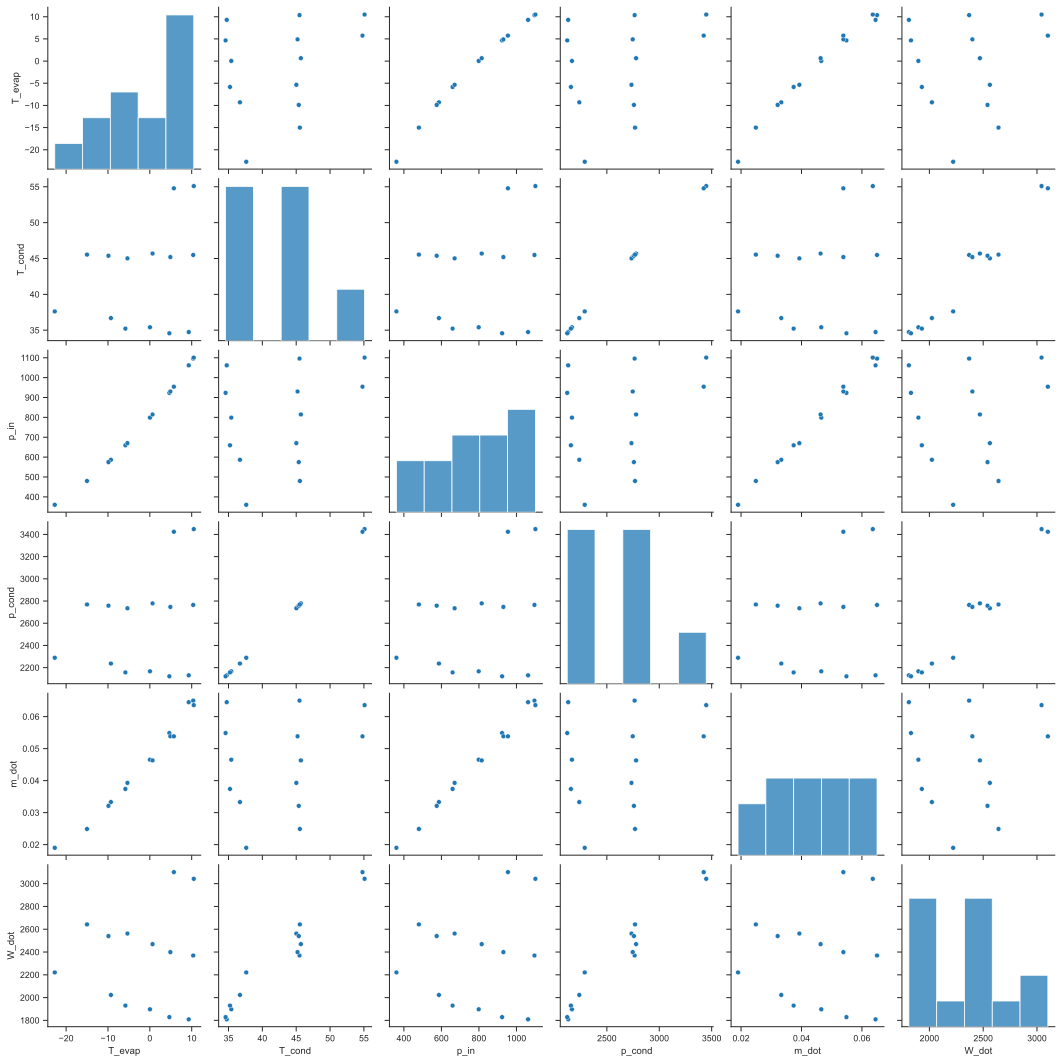

In [ ]:
# Split the dataframe in two dataframes, measured and calculated
df_measured = df[['T_evap', 'T_cond', 'p_in', 'p_cond', 'm_dot', 'W_dot']]
df_calculated = df[['h_in', 'h_out', 's_in', 'h_out_s', 'eta_is']]

# Create a pairwise scatter plot of all the variables
sns.pairplot(df_measured)
plt.show()

### Question 1: Linear model of one variable

Lets make our first model! Let's start with modeling the mass flow rate with just one variable. From inspecting the data, we can see that the mass flow rate is very correlated with the evaporation temperature. This is a good candidate for our first model. Choosing the correct inputs or features is a very important part of the modeling process. Transforming data into features that are useful for modeling is called *feature engineering*. In this case, we will use the evaporation temperature as our feature.

Let's introduce some notation to make our lives easier. We will use **$\mathbf{X}$** to represent our design matrix. The design matrix is a matrix of our input variables, and ones to account for the intercept term, or the "bias" term.

$$
\mathbf{X}  = \begin{bmatrix} 1 & T_{evap,1} \\ 1 & T_{evap,2} \\ \vdots & \vdots \\ 1 & T_{evap,n} \end{bmatrix}
$$

Let's go ahead and create the design matrix for our example.

In [ ]:
num_data = len(df)
x = np.array(df['T_evap'])
X = np.hstack((np.ones((num_data, 1)), x.reshape(-1, 1)))
X

array([[  1.   ,   9.29 ],
       [  1.   ,   4.66 ],
       [  1.   ,  10.36 ],
       [  1.   ,   0.03 ],
       [  1.   ,   4.9  ],
       [  1.   ,  10.49 ],
       [  1.   ,  -5.84 ],
       [  1.   ,   0.65 ],
       [  1.   ,   5.74 ],
       [  1.   ,  -9.3  ],
       [  1.   ,  -5.351],
       [  1.   ,  -9.89 ],
       [  1.   , -15.01 ],
       [  1.   , -22.71 ]])



Let's use **$\mathbf{y}$** to represent our target vector.

$$
\mathbf{y} = m_{\text{dot}}
$$

In [ ]:
y = np.array(df['m_dot'])



Let's introduce the coefficient of our model as a vector of weights

$$
\mathbf{w} = (w_0, w_1)
$$

We want to find the distance between our predicted value and our target value, we can define this as the euclidean norm

$$
L = ||\mathbf{y} - \mathbf{X}\mathbf{w}||^2
$$

where $\mathbf{X}\mathbf{w}$ is the predicted value of our model given by matrix multiplication.

$$
\mathbf{X}\mathbf{w} = \begin{bmatrix} 1 & T_{evap,1} \\ 1 & T_{evap,2} \\ \vdots & \vdots \\ 1 & T_{evap,n} \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}
$$

So our distance between the predicted value and the target value is our loss function.

$$
L = ||\mathbf{y} - \mathbf{X}\mathbf{w}||^2 = \sum_{i=1}^{n} (y_i - (w_0 + w_1 x_{i}))^2
$$

We can then take the derivative of this loss function with respect to our weights and set it equal to zero to find the minimum.

$$
\frac{\partial L}{\partial w} = 0
$$

This gives us a linear system that we can solve for our weights. You can see the full derivation in Professor Bilionis's *Introduction to Data Science* lecture [here](https://purduemechanicalengineering.github.io/me-239-intro-to-data-science/lecture15/regression-with-one-variable-revisited.html)

$$
\mathbf{X}^T\mathbf{X}\mathbf{w} = \mathbf{X}^T\mathbf{y}
$$

To solve for the weights, we can use numpy's `linalg.lstsq` function.

In [ ]:
w_mdot, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

Take a look at the weights

In [ ]:
print(f"w0: {w_mdot[0]:.4f}")
print(f"w1: {w_mdot[1]:.4f}")

w0: 0.0476
w1: 0.0014


We can see how we did by plotting the data and the model.

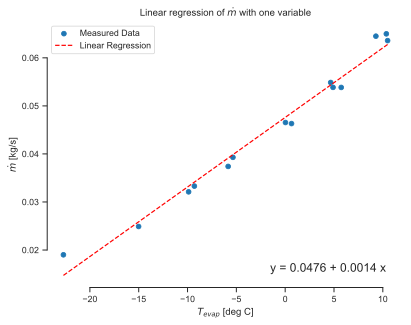

In [ ]:
test_T_evap = np.linspace(df['T_evap'].min(), df['T_evap'].max(), 100)
test_X = np.hstack((np.ones((100, 1)), test_T_evap.reshape(-1, 1)))
test_y = test_X @ w_mdot

plt.figure()
plt.scatter(df['T_evap'], df['m_dot'], label='Measured Data')
plt.plot(test_T_evap, test_y, 'r--', label='Linear Regression')
plt.xlabel(r'$T_{evap}$ [deg C]')
plt.ylabel(r'$\dot{m}$ [kg/s]')
plt.title(r'Linear regression of $\dot{m}$ with one variable')
# Plot the equation of the line
plt.text(0.95, 0.05, f'y = {w_mdot[0]:.4f} + {w_mdot[1]:.4f} x', transform=plt.gca().transAxes, fontsize=12, ha='right', va='bottom')
plt.legend()
sns.despine(trim=True)
plt.show()

Now I want you do go ahead and do the same things for the power consumption. Look through the pairwise plots, then create your design matrix and target vector. Then fit your weights with the same method we used for the mass flow rate. Finally, plot the data and the model. Feel free to copy and paste the code from above then tweka it to do this.

In [ ]:
# YOUR CODE HERE - take as many cells as you need

As you can see, a linear model of one variable is not a good model for the power consumption. We need a more expressive model. Let's take what we learned about linear models of one variables and extend it to something called generalized linear models.

### Question 2: Generalized linear models

*Generalized linear models* (GLMs) are a class of models that are a generalization of linear models. They are a more flexible class of models that can model more complex relationships between the input and target variables.

The form of the generalized linear model is given by:

$$
y(\mathbf{x}, \mathbf{w}) = \sum_{j=1}^m w_j \phi_j(\mathbf{x}) = \mathbf{w}^T \mathbf{\phi}(\mathbf{x})
$$

where $\mathbf{w}$ is our usual vector of weights, and $\mathbf{\phi}(\mathbf{x})$ is a vector of basis functions. It is linear model because the the model is linear in the weights $\mathbf{w}$, but it does not need to be linear in the input variables $\mathbf{x}$. This can be seen through nonlinear basis functions $\mathbf{\phi}(\mathbf{x})$.

Some examples of nonlinear basis functions are:
+ Polynomial basis functions: $\phi_j(\mathbf{x}) = x_j^2$

+ Fourier basis functions: $\phi_{2j}(\mathbf{x}) = \cos\left(\frac{2j\pi}{L} x_j\right)$ and $\phi_{2j+1}(\mathbf{x}) = \sin\left(\frac{2j\pi}{L} x_j\right)$

+ Radial basis functions: $\phi_j(\mathbf{x}) = \exp(-\frac{||x - c_j||^2}{2\sigma_j^2})$

You can think of choosing your basis function as another way to do feature engineering. Using your engineering knowledge of the problem, you can choose a set of basis functions that are appropriate for the problem. For example if you know that the relationship between the input and target variables is periodic, you can use the Fourier basis functions.

From the Air-Condition, Heating, and Refrigeration Institute (AHRI) [Standard 540](https://www.ahrinet.org/system/files/2023-06/AHRI_Standard_540_%28I-P_and_SI%29_2020_Standard_for_Performance_Rating_of_Positive_Displacement_Refrigerant_Compressors_and_Compressor_Units.pdf), we know that a third-order polynomial is a common model form for mass flow rate and power consumption.

The input variables are the evaporation temperature, $T_{evap}$, and the condensing temperature, $T_{cond}$.

The features $\phi(\mathbf{x})$ are
+ The bias term, $\phi_0(\mathbf{x}) = 1$
+ $T_{evap}^n$ for $n = 1, 2, 3$.
+ $T_{cond}^m$ for $m = 1, 2, 3$.
+ $T_{evap}T_{cond}$
+ $T_{evap}^2T_{cond}$
+ $T_{evap}T_{cond}^2$


In our GLM form, we can write the mass flow rate model as:

$$
y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^{9} w_j \phi_j(\mathbf{x})
$$

Or in expanded form:

$$
\dot{m}(\mathbf{x}, \mathbf{w}) = w_0 + w_1 T_{evap} + w_2 T_{cond} + w_3 T_{evap}^2 \\
+ w_4 T_{evap}T_{cond} + w_5 T_{cond}^2 + w_6 T_{evap}^3 + w_7 T_{evap}^2T_{cond}
+ w_8 T_{evap}T_{cond}^2 + w_9 T_{cond}^3
$$

Our design matrix is now defined by the features $\phi(\mathbf{x})$. Let's use sklearn to create our design matrix.

In [ ]:
# Import the PolynomialFeatures class from sklearn
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(df[['T_evap', 'T_cond']])

# print the structure of the design matrix
feature_names = poly.get_feature_names_out()
print(feature_names)


['1' 'T_evap' 'T_cond' 'T_evap^2' 'T_evap T_cond' 'T_cond^2' 'T_evap^3'
 'T_evap^2 T_cond' 'T_evap T_cond^2' 'T_cond^3']


So we can see here that our design matrix has 10 features which correspond to the 10 features we defined earlier. Sklean can do a lot of the heavy lifting for us. We will create the linear model object and then fit it to our target variable.

In [ ]:
# Import the LinearRegression class from sklearn
from sklearn.linear_model import LinearRegression
glm_mdot = LinearRegression()

y = df['m_dot']
glm_mdot.fit(X, y)

# Print the model coefficients
print(glm_mdot.coef_)
print(glm_mdot.intercept_)

[ 0.00000000e+00  5.55127896e-03  4.43740397e-03  7.29347511e-05
 -1.87952205e-04 -8.64554997e-05  5.12028592e-07 -1.19706507e-06
  2.19817792e-06  5.13594589e-07]
-0.02526250785358153


Visualizing the predctions as a function of the inputs with multiple inputs is a bit more difficult. We can look at the response surface over the input space, but it is more customary to look at a scatter plot of the predictions vs the target variable. This is called a parity plot. A perfect model would have all the points lying on the 1:1 line.

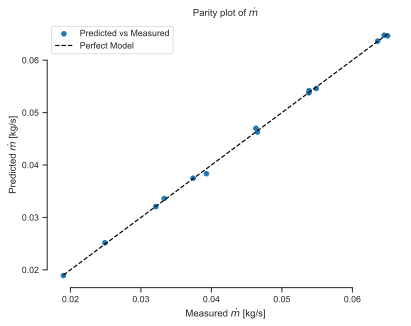

In [ ]:
mdot_pred = glm_mdot.predict(X)
perfect_pred = np.linspace(y.min(), y.max(), 100)

plt.figure()
plt.scatter(y, mdot_pred, label='Predicted vs Measured')
plt.plot(perfect_pred, perfect_pred, 'k--', label='Perfect Model')
plt.xlabel(r'Measured $\dot{m}$ [kg/s]')
plt.ylabel(r'Predicted $\dot{m}$ [kg/s]')
plt.title(r'Parity plot of $\dot{m}$')
plt.legend()
sns.despine(trim=True)
plt.show()

Repeat the same steps for the power consumption.

In [ ]:
# YOUR CODE HERE

Now I want you to make a parity plot for the original model you made of $W_{\text{dot}}$ with one variable.

In [ ]:
# YOUR CODE HERE

We can seee qualitatively that the our generalized linear model is a much better fit for the work consumption model than the linear model of one variable. Visually inspecting the predictions is a perfectly acceptable way to assess model performance, but it can be helpful to have quantative metrics.

### Question 3: Assessing model performance

We can use the mean squared error (MSE) to quantify the performance of our model. The MSE is defined as:

$$
MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i))^2
$$

MSE is the squared error between the predicted and measured values. Smaller values of MSE indicate a better fit. Let's write a function to compute the MSE for any model.

In [ ]:
# Define a function to compute the MSE
def compute_mse(y, y_pred):
    return 1/len(y) * np.sum((y - y_pred)**2)

I will use the MSE to compare the performance of the linear model of one variable and the generalized linear model for the mass flow rate.

In [ ]:
# Compute the MSE for the linear model of one variable
mdot_pred_linear = w_mdot[0] + w_mdot[1] * df['T_evap']
mse_mdot_linear = compute_mse(y, mdot_pred_linear)

# Compute the MSE for the generalized linear model
mdot_pred_glm = glm_mdot.predict(X)
mse_mdot_glm = compute_mse(y, mdot_pred_glm)

# Print the results
print(f"MSE of linear model of one variable: {mse_mdot_linear:.4e}")
print(f"MSE of generalized linear model: {mse_mdot_glm:.4e}")

MSE of linear model of one variable: 3.8929e-06
MSE of generalized linear model: 1.4154e-07


Despite the linear model of one variable performing quite well, the more expressive generalized linear model is a better fit for the data. Differences of such small magnitudes would be difficult to detect visually, but using MSE we can see that the GLM performs better.

Please use the function to calculate the MSE for your two power consumption models.

In [ ]:
# YOUR CODE HERE

Once again, we see that the GLM performs better than the linear model of one variable. The MSE for $\dot{W}$ is signifcantly higher than the MSE for the $\dot{m}$ model, but the parity plot does not look that much worse? To compare two models of different kinds, we can use the relative MSE. It is the ratio of the MSE to the MSE of the mean model.

$$
\text{Relative MSE} = \frac{MSE}{MSE_{\hat{\mu}}} = \frac{\sum_{i=1}^{N} (y_i - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_i))^2}{\sum_{i=1}^{N} (y_i - \hat{\mu})^2}
$$

Make me a function that calculates the relative MSE given measured and predicted values. Then use it to calculate the relative MSE for the two generalized linear models.

In [ ]:
# YOUR CODE HERE

The relative MSE is related to a familiar metric, the coefficient of determination, $R^2$.

$$
R^2 = 1 - \frac{MSE}{MSE_{\hat{\mu}}}
$$

Verify that your function of relative MSE and the $R^2$ are equivalent by using the function to calculate the $R^2$ for the two generalized linear models and comparing it to the sklearn r2_score.

In [ ]:
# YOUR CODE HERE

### Question 4: Using the model

Now that we have a model for the mass flow rate and power consumption, we can use it to predict the outlet enthalpy and efficiency of the compressor at any operating condition. I want you to simple give a point prediction at the given operating condition I give you.

Hint: Do not forget to pass your input variables through the feature mapper.

In [ ]:
T_evap_star = 5 # deg C
T_cond_star = 50 # deg C

In [ ]:
# YOUR CODE HERE

To get a full picture of how our input temperature affect our mass flow rate, we can plot the countour plot of the mass flow with our two temperatures on the axes.

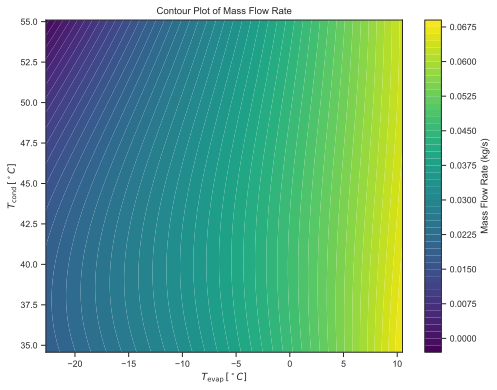

In [ ]:
# Create a grid to evaluate m_dot model on
T_evap_vals = np.linspace(np.min(df['T_evap']), np.max(df['T_evap']), 100)
T_cond_vals = np.linspace(np.min(df['T_cond']), np.max(df['T_cond']), 100)
T_evap_grid, T_cond_grid = np.meshgrid(T_evap_vals, T_cond_vals)
grid_points = np.column_stack((T_evap_grid.ravel(), T_cond_grid.ravel()))

# Pass grid through the feature map
features_grid = poly.transform(grid_points)
# Evaluate the model on grid
m_dot_grid = glm_mdot.predict(features_grid).reshape(T_evap_grid.shape)

# Make contour plot of m_dot with our input variables
plt.figure(figsize=(8,6))
contour = plt.contourf(T_evap_grid, T_cond_grid, m_dot_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='Mass Flow Rate (kg/s)')
plt.xlabel(r'$T_{\mathrm{evap}} \, [^\circ C]$')
plt.ylabel(r'$T_{\mathrm{cond}} \, [^\circ C]$')
plt.title('Contour Plot of Mass Flow Rate')
plt.show()

We can generate a contour plot showing how the predicted mass flow rate varies with evaporator and condenser temperatures. This is done by using a trained regression model to predict mass flow over a grid of temperature values, then overlaying a red contour line representing the manifold—that is, the set of operating conditions—where the mass flow rate is approximately 0.03 kg/s. In other words, the desired mass flow lies on this manifold, which visualizes the temperature combinations that achieve the specified performance target. Feel free to play around with the targeted mass flow rate and see where the different manifolds live.


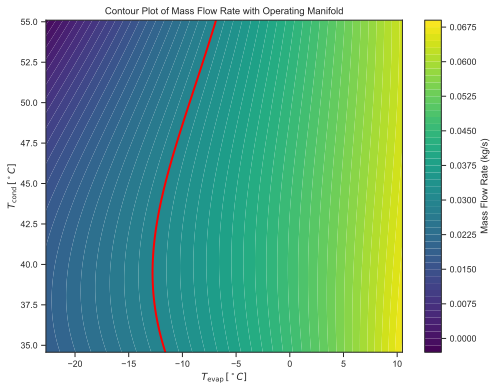

In [ ]:
# Plot the manifold line for desired mdot on top of the filled contour
target_mdot = 0.03

# Create grid for contour plot
T_evap_vals = np.linspace(np.min(df['T_evap']), np.max(df['T_evap']), 100)
T_cond_vals = np.linspace(np.min(df['T_cond']), np.max(df['T_cond']), 100)
T_evap_grid, T_cond_grid = np.meshgrid(T_evap_vals, T_cond_vals)
grid_points = np.column_stack((T_evap_grid.ravel(), T_cond_grid.ravel()))
features_grid = poly.transform(grid_points)
m_dot_grid = glm_mdot.predict(features_grid).reshape(T_evap_grid.shape)

plt.figure(figsize=(8,6))

# Create filled contour plot of m_dot
contourf = plt.contourf(T_evap_grid, T_cond_grid, m_dot_grid, levels=50, cmap='viridis')
plt.colorbar(contourf, label='Mass Flow Rate (kg/s)')


manifold_contour = plt.contour(T_evap_grid, T_cond_grid, m_dot_grid, levels=[target_mdot],
                               colors='red', linewidths=2)

# Extract the manifold path from the contour using the non-deprecated allsegs attribute
if manifold_contour.allsegs[0]:
    # allsegs[0] is a list of arrays, each containing vertices of a contour segment.
    segments = manifold_contour.allsegs[0]
    # Choose the longest segment (i.e., with the most points)
    vertices = max(segments, key=lambda seg: seg.shape[0])

else:
    print("No manifold found for the specified m_dot.")

plt.xlabel(r'$T_{\mathrm{evap}} \, [^\circ C]$')
plt.ylabel(r'$T_{\mathrm{cond}} \, [^\circ C]$')
plt.title('Contour Plot of Mass Flow Rate with Operating Manifold')
plt.show()


Now generate the contour plot for the work consumption, finding the contour for work at 2500 Watts

In [ ]:
# YOUR CODE HERE

These models are very powerful and we can use them to compute valuable parameters, such as the overall isentropic efficiency of this compressor. Because we have limited calculated values of enthalpy, we interpolate between the differences and can generate an efficiency map within the experimental range, using our mass flow and work consumed models. In this code block, we first create a grid of evaporator and condenser temperatures over the range of our data and then transform these points to feed into our predictive models. The mass flow and work consumption models provide estimates of performance over this grid. Since the enthalpy values are only measured at discrete points, we use a triangulation-based linear interpolator to estimate both the inlet and outlet enthalpy across the grid. The difference between these interpolated enthalpy values (converted from kJ/kg to J/kg) is combined with the predicted mass flow and work consumption to calculate the overall isentropic efficiency using the formula:

$$
\eta_{oi} = \frac{\dot{m} \, (h_{out} - h_{in})}{\dot{W}}
$$

Finally, a filled contour plot is generated to visualize the efficiency map, showing how efficiency varies with different operating conditions.


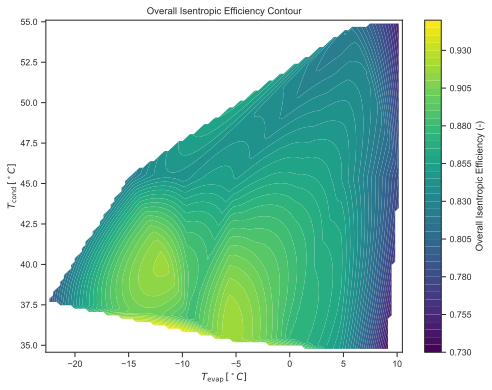

In [ ]:
import matplotlib.tri as tri

# 1. Create a grid of T_evap and T_cond
T_evap_vals = np.linspace(df['T_evap'].min(), df['T_evap'].max(), 100)
T_cond_vals = np.linspace(df['T_cond'].min(), df['T_cond'].max(), 100)
T_evap_grid, T_cond_grid = np.meshgrid(T_evap_vals, T_cond_vals)
grid_points = np.column_stack([T_evap_grid.ravel(), T_cond_grid.ravel()])

# 2. Predict m_dot and W_dot at each grid point
features_grid = poly.transform(grid_points)
m_dot_grid = glm_mdot.predict(features_grid).reshape(T_evap_grid.shape)
X_wdot = poly.fit_transform(df[['T_evap', 'T_cond']])
y_wdot = df['W_dot']
glm_wdot = LinearRegression()
glm_wdot.fit(X_wdot, y_wdot)
W_dot_grid = glm_wdot.predict(features_grid).reshape(T_evap_grid.shape)

# 3. Interpolate h_in and h_out over the same grid using triangulation
#    from the measured data in df.
triang = tri.Triangulation(df['T_evap'], df['T_cond'])

# Create interpolators for h_in and h_out
interp_h_in = tri.LinearTriInterpolator(triang, df['h_in'])
interp_h_out = tri.LinearTriInterpolator(triang, df['h_out'])

h_in_grid = interp_h_in(T_evap_grid, T_cond_grid)
h_out_grid = interp_h_out(T_evap_grid, T_cond_grid)

# 4. Compute enthalpy difference in J/kg (since data is in kJ/kg)
#    h_diff [J/kg] = (h_out - h_in) * 1000
h_diff_grid = (h_out_grid - h_in_grid) * 1000.0

# 5. Compute overall isentropic efficiency:
#    eta_oi = (m_dot * h_diff) / W_dot
#    Check for divide-by-zero or invalid values:
with np.errstate(divide='ignore', invalid='ignore'):
    eta_oi_grid = (m_dot_grid * h_diff_grid) / W_dot_grid

# 6. Plot the isentropic efficiency as a filled contour
plt.figure(figsize=(8, 6))
contour_eff = plt.contourf(
    T_evap_grid, T_cond_grid, eta_oi_grid,
    levels=50, cmap='viridis'
)
cbar = plt.colorbar(contour_eff)
cbar.set_label('Overall Isentropic Efficiency (-)')

plt.xlabel(r'$T_{\mathrm{evap}} \, [^\circ C]$')
plt.ylabel(r'$T_{\mathrm{cond}} \, [^\circ C]$')
plt.title('Overall Isentropic Efficiency Contour')
plt.show()

I hope you can appreciate how useful it is to do regression on problems with limited data. By predicting compressor performance in operating conditions without observed data, we can inform additional testing or optimize our design parameters, leading to more targeted experiments. This approach helps identify promising operating conditions, reduces experimental costs, and ultimately guides us in improving efficiency and system reliability.